# 0.Служебный блок

## 0.Установка библиотек

In [5]:
#Base
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# #Google Drive
# from google.colab import drive

# Load Data
import wget

# Metrics
from sklearn.metrics import classification_report, roc_curve,\
 RocCurveDisplay, auc

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Train Test Split
from sklearn.model_selection import train_test_split, GridSearchCV

# Scaling
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

# Encoding
from sklearn.preprocessing import OneHotEncoder

'''#Sampling
from imblearn.over_sampling import ADASYN, SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTEENN, SMOTETomek'''

#Missing values
from sklearn.impute import KNNImputer, SimpleImputer

#Pipline
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

#Parallel processes
from dask.distributed import Client, LocalCluster
from dask.diagnostics import ProgressBar
from joblib import dump, load
import joblib

## 0.1.Функции для обработки

In [6]:
def categorical_pie_chart(data: pd.DataFrame,
                          cols: int = 4,
                          legend: bool = False,
                          figsize: tuple = (18, 18)):
  """
  Эта процедура создаёт сетку из круговых диаграмм для категориальных признаков,
  на которых отображены процентные соотношения значений в столбце.

  :param df: данные для которых построена диаграмма
  :type dataset_directory: pandas.DataFrame

  :param cols: количество диаграмм в строке
  :type root_directory: ште

  :param legend: отвечает за отображение легенды
  :type categories: str


  :param figsize: отвечает за размер области
  :type categories: tuple(int, int)

  :raises None

  :rtype: None
  :return: None
  """

  df = data.copy()
  df.replace(to_replace=[r'^\s*$', None, 'None,' 'Nan', 'NaN'],
             value='None',
             regex=True,
             inplace=True)
  features = list(df.select_dtypes(include='object').columns)
  rows = int(-1 * (len(features) / cols) // 1 * -1)
  fig, ax = plt.subplots(rows, cols, figsize=figsize)

  row = 0
  col = 0
  for i, feature in enumerate(features):
    ax[row, col].pie(df[feature].value_counts(),
                    autopct='%.2f',
                    labels=df[feature].value_counts().index)
    ax[row, col].set_title(feature)
    col += 1
    if col // cols == 1:
      row += 1
      col = 0


def numeric_features_distplot(df: pd.DataFrame,
                              cols: int = 3,
                              kde: bool = True,
                              figsize: tuple = (18, 18)):
  """
  Эта процедура создаёт сетку из круговых диаграмм для категориальных признаков,
  на которых отображены процентные соотношения значений в столбце.

  :param df: данные для которых построена диаграмма
  :type dataset_directory: pandas.DataFrame

  :param cols: количество диаграмм в строке
  :type root_directory: ште

  :param kde: отвечает за отображение полинома
  :type categories: str


  :param figsize: отвечает за размер области
  :type categories: tuple(int, int)

  :raises None

  :rtype: None
  :return: None
  """

  features = list(df.select_dtypes(exclude='object').columns)
  rows = int(-1 * (len(features) / cols) // 1 * -1)
  fig, ax = plt.subplots(rows, cols, figsize=figsize)

  row = 0
  col = 0
  for i, feature in enumerate(features):
    sns.histplot(x = df[feature],
                kde = kde,
                data = df,
                ax=ax[row, col])

    #ax[row, col].set_title(feature)
    col += 1
    if col // cols == 1:
      row += 1
      col = 0



# 1.Обработка данных

## 1.1.Скачивание данных

In [7]:
# drive.mount('/content/drive')
test_dataset = pd.read_csv('dataset/hotel_test.csv')
train_dataset = pd.read_csv('dataset/hotel_train.csv')

## 1.2.Первичная обработка данных

In [8]:
train_dataset.sample(3)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
18071,26011,1,46.0,2015,August,34,17,1,1,1.0,...,0,0,0,A,1,0,Transient-Party,0,0,2
299,305,0,6.0,2015,July,29,17,1,2,2.0,...,0,0,0,D,0,0,Contract,0,0,3
64056,82771,0,36.0,2016,December,49,1,2,3,2.0,...,0,0,0,A,0,0,Transient,0,1,5


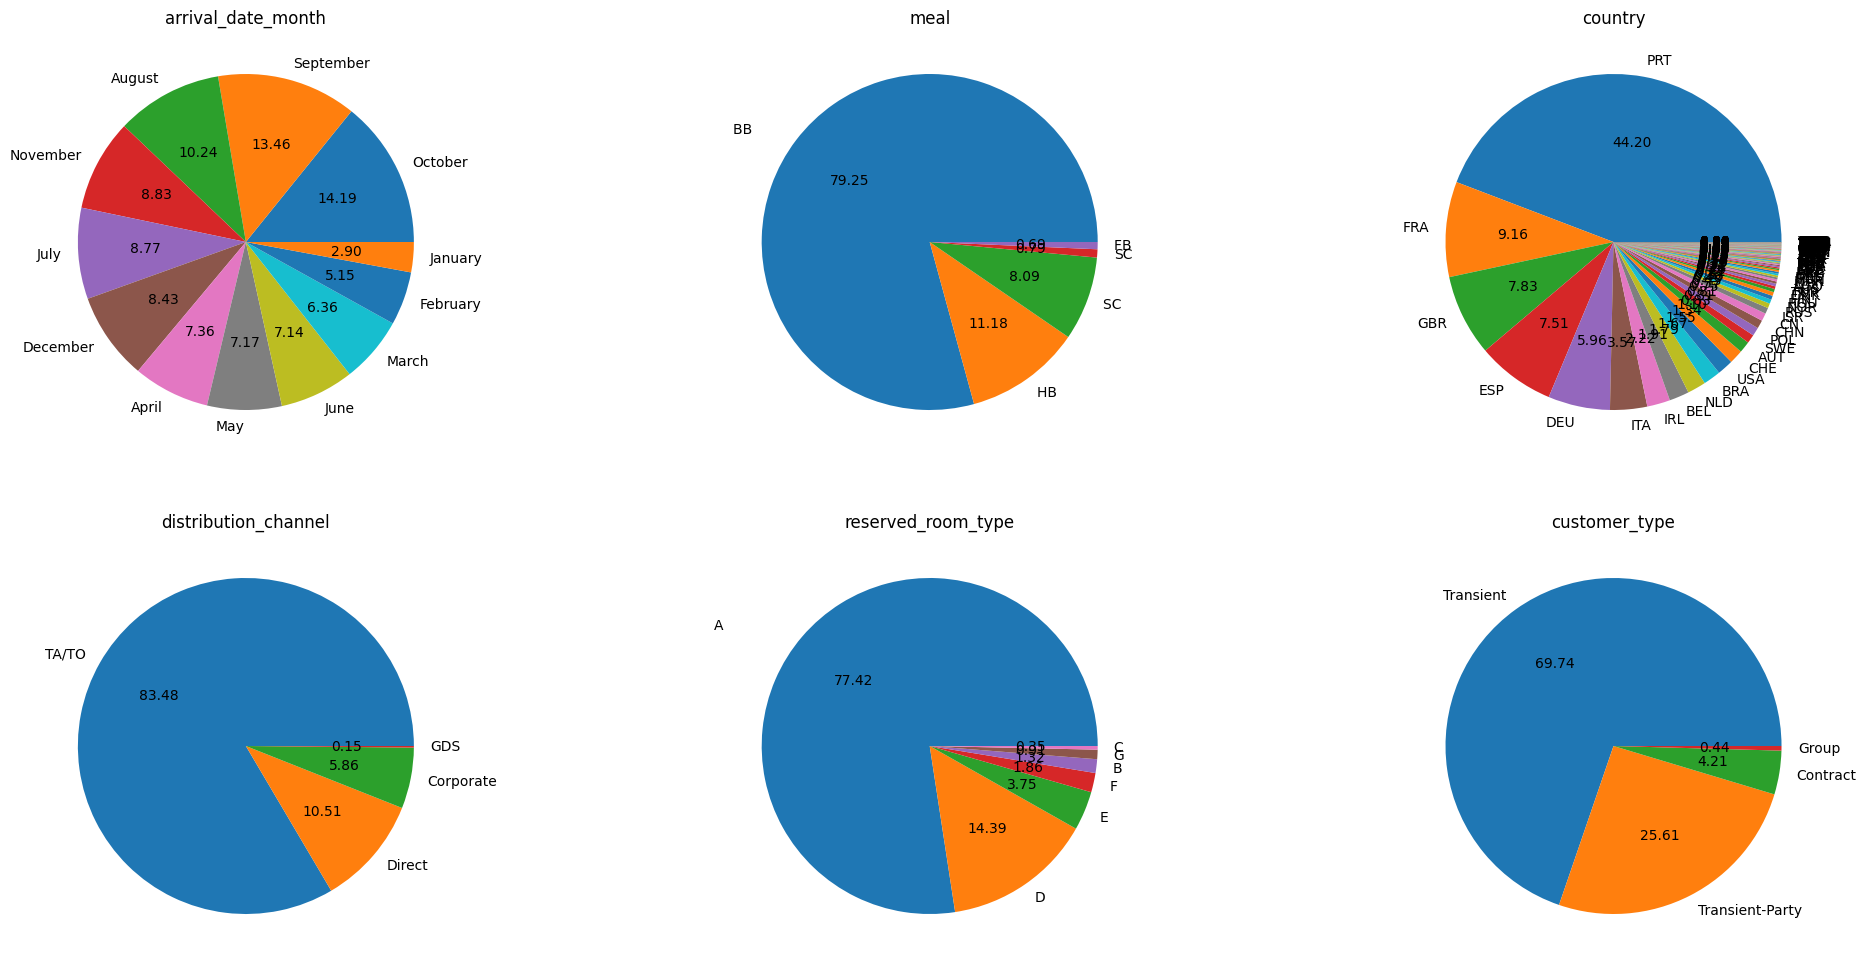

In [9]:
categorical_pie_chart(train_dataset, figsize=(25, 12), cols=3)

В графе 'countries' много значений с малой долей представленности в датасете. Занесём в список названия этих стран

In [10]:
countries = list(train_dataset['country'].value_counts()[train_dataset['country'].value_counts() < 10].index)
countries = set(countries)
len(train_dataset[train_dataset['country'].isin(countries) == True])

204

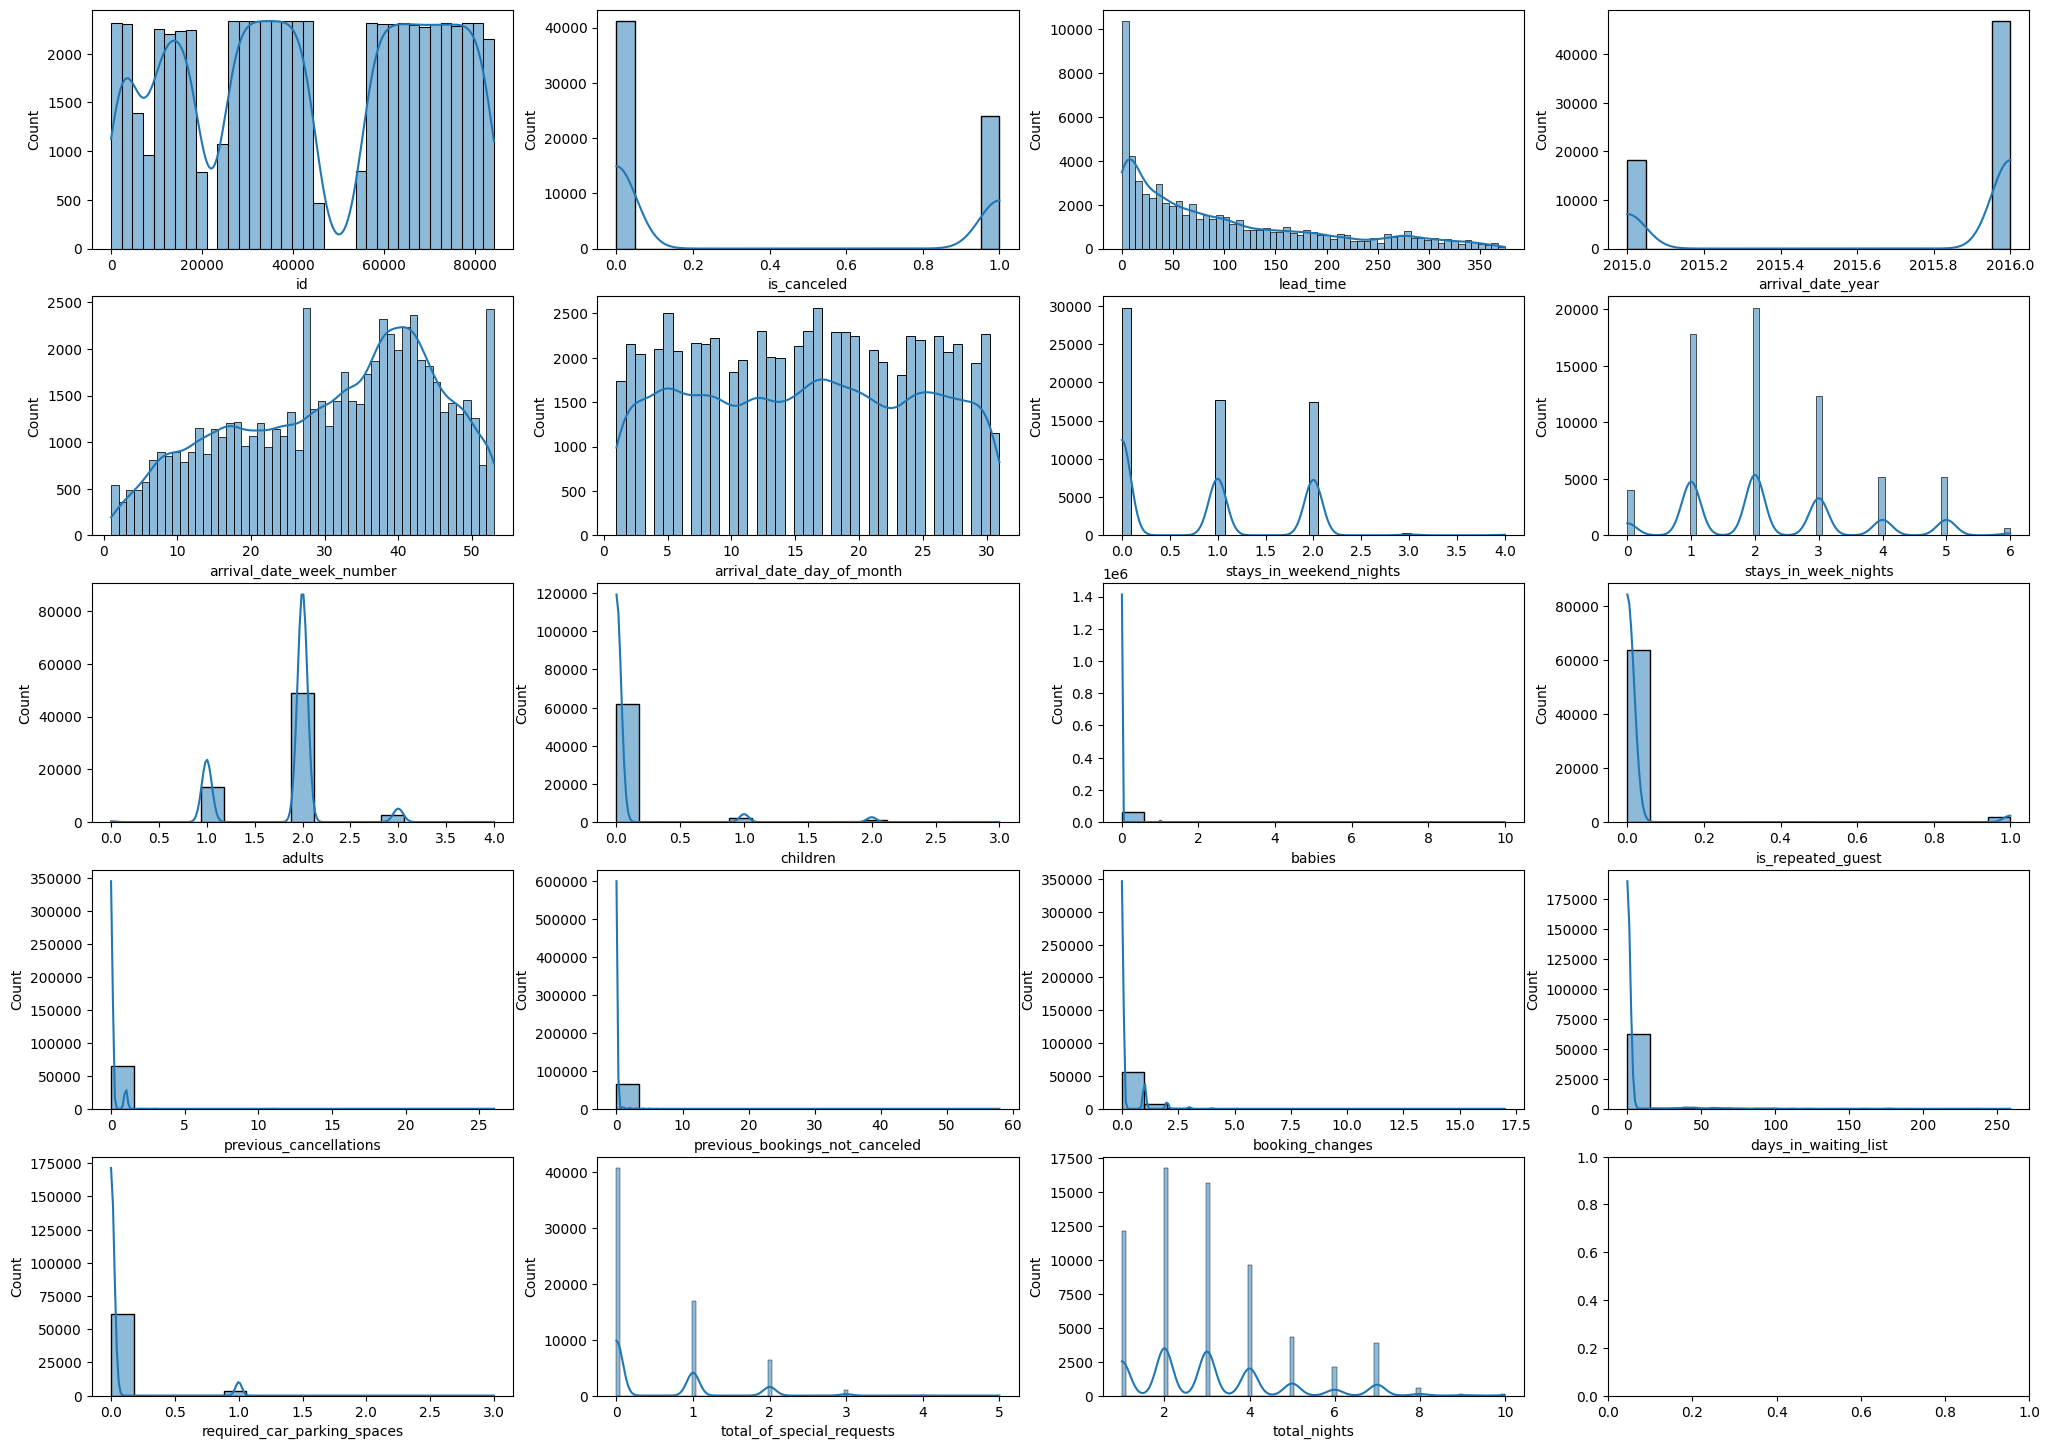

In [11]:
numeric_features_distplot(train_dataset, cols=4, figsize=(25, 18))

<Axes: >

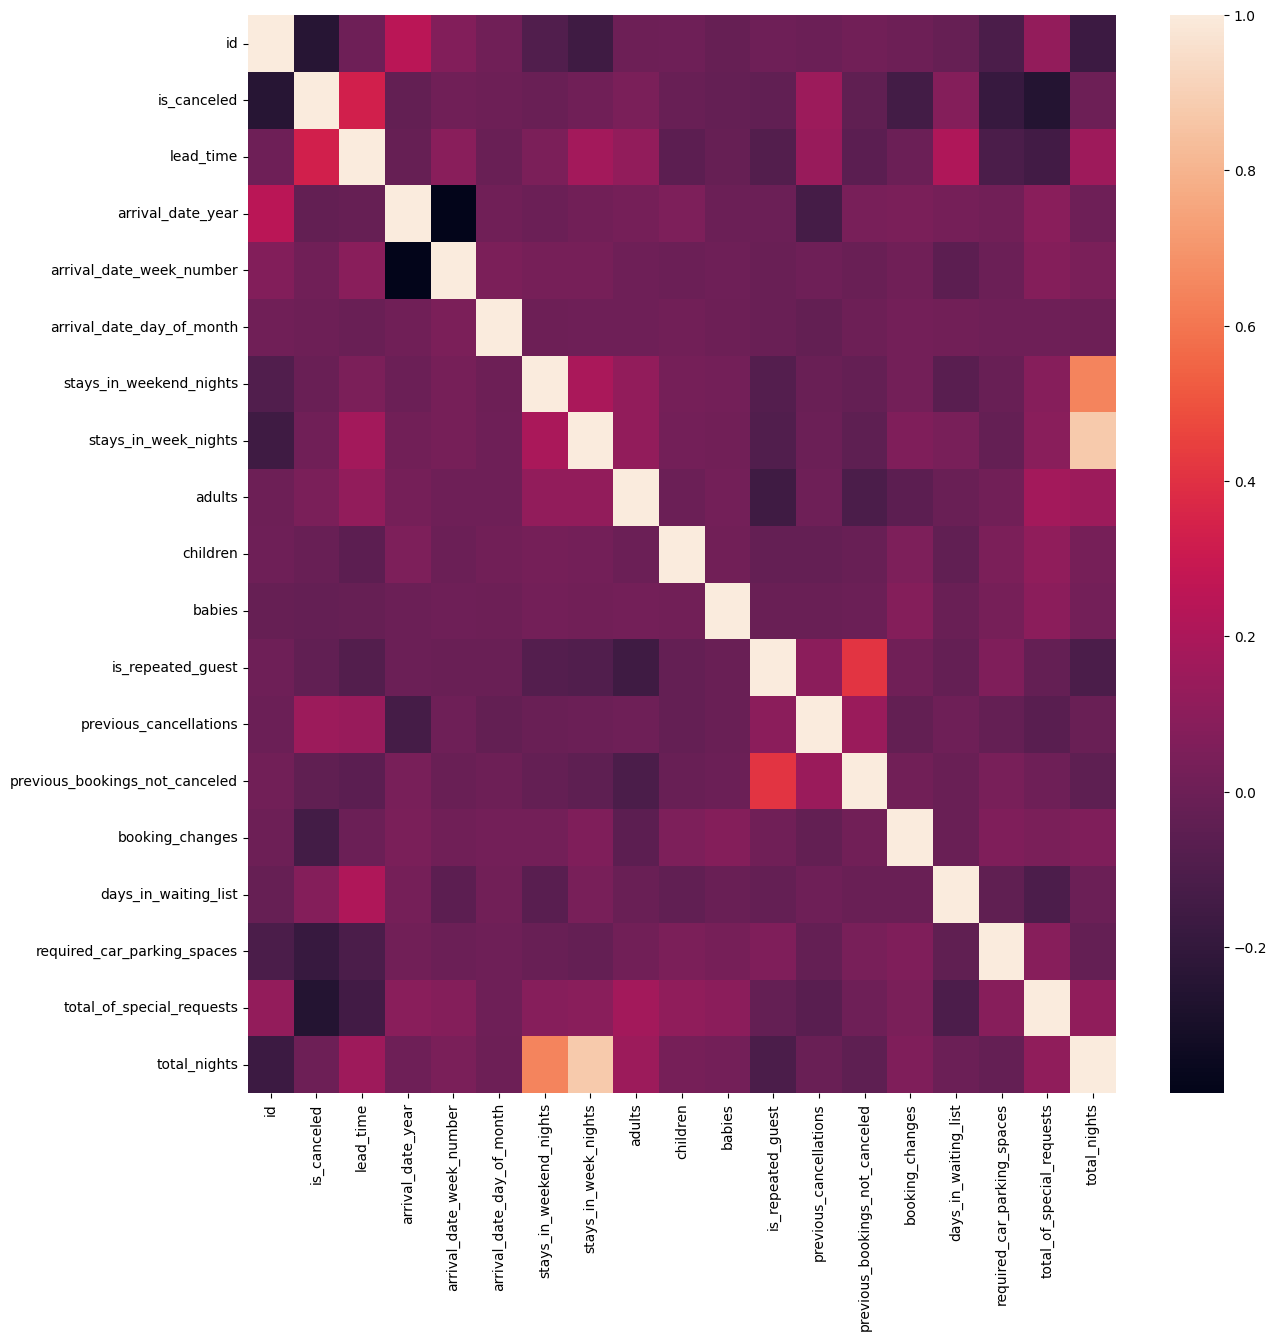

In [12]:
plt.figure(figsize=(14,14))
sns.heatmap(train_dataset.select_dtypes(exclude='object').corr(),annot=False)

In [13]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

In [14]:
train_dataset.duplicated().sum()

0

In [15]:
train_dataset.describe()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000
mean,43544.069172,0.368609,96.337917,2015.719021,31.339772,15.847813,0.825185,2.224793,1.836576,0.074890,0.007236,0.027151,0.128915,0.107713,0.194269,3.334422,0.056647,0.512763,3.049978
std,25614.858971,0.482431,96.127545,0.449481,13.464024,8.748182,0.853477,1.354992,0.480245,0.334243,0.098790,0.162523,0.965326,1.326638,0.593838,18.239606,0.232094,0.752590,1.738108
min,0.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,19108.000000,0.000000,17.000000,2015.000000,21.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,40554.000000,0.000000,64.000000,2016.000000,34.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,67414.000000,1.000000,151.000000,2016.000000,42.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,84121.000000,1.000000,374.000000,2016.000000,53.000000,31.000000,4.000000,6.000000,4.000000,3.000000,10.000000,1.000000,26.000000,58.000000,17.000000,259.000000,3.000000,5.000000,10.000000


## 1.3.Очистка данных

In [16]:
drop_columns = ['id', 'stays_in_week_nights']

categorical_columns = [
    'arrival_date_month',
    'meal',
    'country',
    'distribution_channel',
    'reserved_room_type',
    'customer_type',
    'arrival_date_year',
    'arrival_date_week_number'
    ]

numeric_columns = [
    'lead_time',
    'arrival_date_day_of_month',
    'stays_in_weekend_nights',
    'adults',
    'children',
    'babies',
    'is_repeated_guest',
    'previous_cancellations',
    'previous_bookings_not_canceled',
    'booking_changes',
    'days_in_waiting_list',
    'required_car_parking_spaces',
    'total_of_special_requests',
    'total_nights'
]

target = 'is_canceled'

In [17]:
train_dataset = train_dataset[train_dataset['country'].isin(countries) == False]
train_dataset.drop(columns=drop_columns, inplace=True)
train_dataset.rename(columns={'is_canceled': target})

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,adults,children,babies,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,7.0,2015,July,27,1,0,1.0,0.0,0.0,...,0,0,0,A,0,0,Transient,0,0,1
1,0,14.0,2015,July,27,1,0,2.0,0.0,0.0,...,0,0,0,A,0,0,Transient,0,1,2
2,0,0.0,2015,July,27,1,0,2.0,0.0,0.0,...,0,0,0,C,0,0,Transient,0,0,2
3,0,9.0,2015,July,27,1,0,2.0,0.0,0.0,...,0,0,0,C,0,0,Transient,0,1,2
4,1,85.0,2015,July,27,1,0,2.0,0.0,0.0,...,0,0,0,A,0,0,Transient,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65224,0,23.0,2016,December,53,30,2,2.0,0.0,0.0,...,0,0,0,D,0,0,Transient,0,2,6
65225,0,53.0,2016,December,53,31,2,2.0,0.0,0.0,...,0,0,0,D,0,0,Transient,0,3,5
65226,0,7.0,2016,December,53,31,2,2.0,0.0,0.0,...,0,0,0,D,0,0,Transient,0,1,6
65227,0,17.0,2016,December,53,30,2,2.0,0.0,0.0,...,0,0,0,A,0,0,Transient,0,1,7


## 1.4.Вывод по первичному анализу данных


1. Данные хорошие, нет пропусков и явных выбросов;
2. Колонка 'stays_in_week_nights' скоррелирована с колонкой 'total_nights' и удалена из данных, колонка 'id' удалена за неинформативностью;
3. Признак arrival_date_year перенеён в категориальные т.к. имеет всего два оригинальных значения. Стоит рассмотреть возможность его удаления из данных, т.к. он может быть малоинформативен;
4. Среди значений колонки 'country' есть значения, представленные в датасете менее чем 10 примерами. Для повышения обобщающей способности они удалены из данных.

# 2.Моделирование


In [18]:
X_train, x_valid, Y_train, y_valid = train_test_split(
    train_dataset.drop(columns=target),
    train_dataset[target],
    test_size=0.2,
    random_state=101
)

## 2.1.Создание пайплайна работы с числовыми фичами

In [19]:
knn_imputer = KNNImputer(
    missing_values=np.nan,
    n_neighbors=5,
    weights = 'distance'
)
r_scaler = RobustScaler()

pipe_num = Pipeline(
    [
        ('imputer', knn_imputer),
        ('scaler', r_scaler)
    ]
)

In [20]:
# res_num = train_dataset[numeric_columns]
# res_num = pipe_num.fit_transform(res_num)
# res_num_df = pd.DataFrame(
#    res_num,
#    columns=numeric_columns
# )
# res_num_df.sample(3)
# pipe_num['scaler'].get_features_name_out(train_dataset[numeric_columns].columns, axis=1)

## 2.2.Создание пайплайна работы с категориальными фичами

In [21]:
simp_imputer = SimpleImputer(
    missing_values=np.nan,
    strategy='constant',
    fill_value='unknown'
)
ohe_enc = OneHotEncoder(
    handle_unknown='ignore',
    sparse_output=False
)

pipe_cat = Pipeline(
    [
        ('imputer', simp_imputer),
        ('encoder', ohe_enc)
    ]
)

# res_cat = pipe_cat.fit_transform(res_cat)
# res_cat = train_dataset[categorical_columns]
# res_cat_df = pd.DataFrame(
#    res_cat,
#    columns=pipe_cat.get_feature_names_out()
# )
# res_cat_df.sample(3)

## 2.3.Создание общего пайплайна обработки

In [22]:
#column transformer with missing types
col_transformer = ColumnTransformer(
    [
        ('num_preproc', pipe_num, numeric_columns),
        ('cat_preproc', pipe_cat, categorical_columns)
    ]
)
col_transformer

ColumnTransformer(transformers=[('num_preproc',
                                 Pipeline(steps=[('imputer',
                                                  KNNImputer(weights='distance')),
                                                 ('scaler', RobustScaler())]),
                                 ['lead_time', 'arrival_date_day_of_month',
                                  'stays_in_weekend_nights', 'adults',
                                  'children', 'babies', 'is_repeated_guest',
                                  'previous_cancellations',
                                  'previous_bookings_not_canceled',
                                  'booking_changes', 'days_in_waiting_list',
                                  '...
                                  'total_of_special_requests',
                                  'total_nights']),
                                ('cat_preproc',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='unknown',
                                                                strategy='constant')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['arrival_date_month', 'meal', 'country',
                                  'distribution_channel', 'reserved_room_type',
                                  'customer_type', 'arrival_date_year',
                                  'arrival_date_week_number'])])

In [23]:
res = col_transformer.fit_transform(X_train)
#res_df = pd.DataFrame(res, columns = [x.split('__')[-1] for x in col_transformer.get_feature_names_out()])
#res_df.sample(3)

## 3.3.Перебор моделей и гиперапараметров

### 3.3.1.Dask

In [24]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 15.85 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:60376,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 15.85 GiB
Comm: tcp://127.0.0.1:60399,Total threads: 3
Dashboard: http://127.0.0.1:60400/status,Memory: 3.96 GiB
Nanny: tcp://127.0.0.1:60379,


### 3.3.2 LogisticRedression and RandomForestClassifier

In [25]:
pipe = Pipeline(
    [
        ('preproc', col_transformer),
        ('model', 'passthrough')
    ]
)

param_grid = [
    {
        'model': [LogisticRegression()],
        'model__class_weight': ['balanced'],
        'model__solver': ['lbfgs', 'saga', ],
        'model__penalty': ['l2'],
        'model__C': [1, 10, 100]
    },
    # {
    #     'model': [SVC()],
    #     'model__kernel': ['rbf', 'poly'],
    #     'model__degree': [1, 2, 3],
    #     'model__gamma': ['scale', 'auto'],
    #     'model__C': [1, 10, 100]
    # },
    {
        'model': [RandomForestClassifier(random_state=101)],
        'model__n_estimators': [100, 300, 500, 1000],
        'model__max_depth': [3, 5, 8, 15],
        'model__max_features': ["log2", "sqrt", "auto"]
    }
]

gs = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    scoring = 'f1_macro',
    cv = 5,
    verbose = 0,
    n_jobs = -1
)

gs

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(transformers=[('num_preproc',
                                                                         Pipeline(steps=[('imputer',
                                                                                          KNNImputer(weights='distance')),
                                                                                         ('scaler',
                                                                                          RobustScaler())]),
                                                                         ['lead_time',
                                                                          'arrival_date_day_of_month',
                                                                          'stays_in_weekend_nights',
                                                                          'adults',
                                                                          'children',
                                                                          'babies',
                                                                          'is_repeated_guest',
                                                                          'previous_cancellations',
                                                                          'previous_bookings_n...
             n_jobs=-1,
             param_grid=[{'model': [LogisticRegression()],
                          'model__C': [1, 10, 100],
                          'model__class_weight': ['balanced'],
                          'model__penalty': ['l2'],
                          'model__solver': ['lbfgs', 'saga']},
                         {'model': [RandomForestClassifier(random_state=101)],
                          'model__max_depth': [3, 5, 8, 15],
                          'model__max_features': ['log2', 'sqrt', 'auto'],
                          'model__n_estimators': [100, 300, 500, 1000]}],
             scoring='f1_macro')

In [27]:
ans = input('Провести поиск по сетке заново [y] - да; [n] - нет')
if ans == 'y':
    with joblib.parallel_backend('dask'):
        gs.fit(X_train, Y_train)
    dump(gs, 'grid_search_3_3.joblib')
elif ans == 'n':
    gs = load('grid_search_3_3.joblib')

2024-01-14 22:06:37,986 - tornado.application - ERROR - Exception in callback <bound method BokehTornado._keep_alive of <distributed.dashboard.core.DaskBokehTornado object at 0x000002C9130A4790>>
Traceback (most recent call last):
  File "e:\My_projects\.venv\Lib\site-packages\tornado\ioloop.py", line 937, in _run
    val = self.callback()
          ^^^^^^^^^^^^^^^
  File "e:\My_projects\.venv\Lib\site-packages\bokeh\server\tornado.py", line 787, in _keep_alive
    c.send_ping()
  File "e:\My_projects\.venv\Lib\site-packages\bokeh\server\connection.py", line 91, in send_ping
    self._socket.ping(str(self._ping_count).encode("utf-8"))
  File "e:\My_projects\.venv\Lib\site-packages\tornado\websocket.py", line 440, in ping
    raise WebSocketClosedError()
tornado.websocket.WebSocketClosedError
2024-01-14 22:06:38,460 - tornado.application - ERROR - Exception in callback <bound method BokehTornado._keep_alive of <distributed.dashboard.core.DaskBokehTornado object at 0x000002C9130A4790>>
T

In [28]:
gs.best_estimator_.named_steps['model']

RandomForestClassifier(max_depth=15, n_estimators=1000, random_state=101)

In [29]:
y_pred = gs.predict(x_valid)
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.96      0.90      8300
           1       0.91      0.67      0.77      4705

    accuracy                           0.86     13005
   macro avg       0.87      0.82      0.83     13005
weighted avg       0.86      0.86      0.85     13005



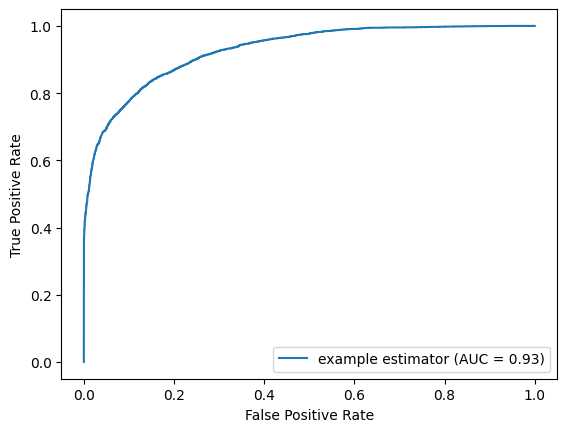

In [31]:
y_pred_proba = gs.predict_proba(x_valid)[::,1]
fpr, tpr, _ = roc_curve(y_valid, y_pred_proba)

#create ROC curve
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                          estimator_name='example estimator')
display.plot()
plt.show()

### 3.3.3.SVC

In [26]:
param_grid = [
    # {
    #     'model': [LogisticRegression()],
    #     'model__class_weight': ['balanced'],
    #     'model__solver': ['lbfgs', 'saga', ],
    #     'model__penalty': ['l2'],
    #     'model__C': [1, 10, 100]
    # },
    {
        'model': [SVC()],
        'model__kernel': ['rbf', 'poly'],
        'model__degree': [1, 2, 3],
        'model__gamma': ['scale', 'auto'],
        'model__C': [1, 10, 100]
    },
    # {
    #     'model': [RandomForestClassifier(random_state=101)],
    #     'model__n_estimators': [100, 300, 500, 1000],
    #     'model__max_depth': [3, 5, 8, 15],
    #     'model__max_features': ["log2", "sqrt", "auto"]
    # }
]

gs = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    scoring = 'f1_macro',
    cv = 5,
    verbose = 0,
    n_jobs = -1
)
gs

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(transformers=[('num_preproc',
                                                                         Pipeline(steps=[('imputer',
                                                                                          KNNImputer(weights='distance')),
                                                                                         ('scaler',
                                                                                          RobustScaler())]),
                                                                         ['lead_time',
                                                                          'arrival_date_day_of_month',
                                                                          'stays_in_weekend_nights',
                                                                          'adults',
                                                                          'children',
                                                                          'babies',
                                                                          'is_repeated_guest',
                                                                          'previous_cancellations',
                                                                          'previous_bookings_n...
                                                                                                        sparse_output=False))]),
                                                                         ['arrival_date_month',
                                                                          'meal',
                                                                          'country',
                                                                          'distribution_channel',
                                                                          'reserved_room_type',
                                                                          'customer_type',
                                                                          'arrival_date_year',
                                                                          'arrival_date_week_number'])])),
                                       ('model', 'passthrough')]),
             n_jobs=-1,
             param_grid=[{'model': [SVC()], 'model__C': [1, 10, 100],
                          'model__degree': [1, 2, 3],
                          'model__gamma': ['scale', 'auto'],
                          'model__kernel': ['rbf', 'poly']}],
             scoring='f1_macro')

In [27]:
ans = input('Провести поиск по сетке заново [y] - да; [n] - нет')
if ans == 'y':
    with joblib.parallel_backend('dask'):
        gs.fit(X_train, Y_train)
    dump(gs, 'grid_search_3_3_3.joblib')
elif ans == 'n':
    gs = load('grid_search_3_3_3.joblib')
gs.best_estimator_.named_steps['model']

In [ ]:
y_pred = gs.predict(x_valid)
print(classification_report(y_valid, y_pred))

In [ ]:
y_pred_proba = gs.predict_proba(x_valid)[::,1]
fpr, tpr, _ = roc_curve(y_valid, y_pred_proba)

#create ROC curve
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                          estimator_name='example estimator')
display.plot()
plt.show()